In [26]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from urllib.parse import urlparse
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [4]:
# DATA FILES

price_files = ["bittensor_token_price.csv", "fetchai_token_price.csv",
               "numerai_token_price.csv", "oceanprotocol_token_price.csv",
               "oraichain_token_price.csv", "singularitynet_token_price.csv"]

commits_mapping = {
    "bittensor_commits.json": "TAO",
    "fetchai_commits.json": "FET",
    "numerai_commits.json": "NMR", 
    "oceanprotocol_commits.json": "OCEAN",
    "oraichain_commits.json": "ORAI",
    "singularitynet_commits.json": "AGIX"
}

repos_mapping = {
    "bittensor_repos.json": "TAO",
    "fetchai_repos.json": "FET",
    "numerai_repos.json": "NMR", 
    "oceanprotocol_repos.json": "OCEAN",
    "oraichain_repos.json": "ORAI",
    "singularitynet_repos.json": "AGIX"
}

tokens = ["TAO", "FET", "NMR",
          "OCEAN", "ORAI", "AGIX"]

In [17]:
# IDEA: use get_commits to extract commit data
# parse url to extract the repo (idea below forom chatgpt)
# the group by repo and rank based on total commits
# plot evolution of different repos

def extract_repo_name(url):
    path = urlparse(url).path
    # The repo name is the third part of the path
    repo_name = path.split('/')[2]
    return repo_name

def get_commits(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'github_data/{k}'
            with open(filename) as commits_file:
                parsed_json = json.load(commits_file)
            
            commits_rows = [row for sublist in parsed_json for row in sublist]
            commits_df = pd.DataFrame(commits_rows)
            return commits_df
    return f'No commit data for token {token}'


def get_commit_trends(commits_df):
    # Flatten JSON data for commit and author
    flat_commit = pd.json_normalize(commits_df['commit'])
    commits_df = pd.concat([commits_df, flat_commit], axis=1)
    commits_df.drop(columns=['commit'], inplace=True)


    # Convert author date to datetime and extract date part
    commits_df['author.date'] = pd.to_datetime(commits_df['author.date']).dt.date
    commits_df['repo_name'] = commits_df['html_url'].apply(extract_repo_name)

    # Count occurrences by date and ID
    date_counts = commits_df.groupby(['author.date', 'repo_name']).size().reset_index(name='count')
    
    
    # Convert 'author.date' column to datetime
    date_counts['author.date'] = pd.to_datetime(date_counts['author.date'])
    date_counts['year'] = date_counts['author.date'].dt.year

    # Resampling helper function
    def resample_data(df, freq):
        resampled = df.set_index('author.date').groupby('repo_name').resample(freq)['count'].sum().reset_index()
        return resampled

    # Resample into yearly, monthly, and weekly intervals
    yearly_counts = resample_data(date_counts, 'Y')
    monthly_counts = resample_data(date_counts, 'M')
    weekly_counts = resample_data(date_counts, 'W')

    return yearly_counts, monthly_counts, weekly_counts



In [34]:
def preprocess_trends(commits_df, token):
    repo_rank = pd.DataFrame()
    repo_rank['date'] = commits_df['author.date']
    repo_rank['year'] = commits_df['author.date'].dt.year
    repo_rank['week'] = commits_df['author.date'].dt.isocalendar().week
    repo_rank['total'] = commits_df.groupby(['repo_name', 'author.date'])['count'].cumsum().values
    repo_rank['repo_name'] = commits_df['repo_name']
    repo_rank['project'] = token

    return repo_rank

def plot_evolution_graph(rank_df, time_frame, token):
    # Rank repositories based on the total commits for each date
    rank_df['rank'] = rank_df.groupby('date')['total'].rank(method='first', ascending=False)
    
    # Filter to top 10 ranks at each date
    top_rank_df = rank_df.groupby('date').apply(lambda x: x.nlargest(10, 'total')).reset_index(drop=True)

    # Aggregate counts to handle duplicates
    top_rank_df = top_rank_df.groupby(['date', 'repo_name'], as_index=False)['total'].sum()

    # Recompute ranks after aggregation
    top_rank_df['rank'] = top_rank_df.groupby('date')['total'].rank(method='first', ascending=False)

    # Ensure 'date' is a string to use as x-tick labels
    top_rank_df['date'] = top_rank_df['date'].astype(str)

    # Pivot the data to get the rank evolution for each repository
    rank_evolution = top_rank_df.pivot_table(index='date', columns='repo_name', values='rank', aggfunc='first')

    # Generate unique colors for each repository
    unique_repos = rank_evolution.columns
    num_repos = len(unique_repos)
    colors = list(mcolors.TABLEAU_COLORS.values())
    if num_repos > len(colors):
        colors = plt.cm.get_cmap('tab20', num_repos).colors
    color_map = {repo: colors[i] for i, repo in enumerate(unique_repos)}

    # Plot the evolution of repository rankings over time
    plt.figure(figsize=(12, 8))
    for repo_name in rank_evolution.columns:
        plt.plot(rank_evolution.index, rank_evolution[repo_name], marker='o', label=repo_name, color=color_map[repo_name])

    plt.ylim(0.5, 10.5)  # Set y-axis limits for top 10 repositories
    plt.gca().invert_yaxis()  # Invert y-axis to show rank 1 at the top
    plt.xlabel('Date')
    plt.ylabel('Rank')
    plt.title(f'{time_frame} Evolution of Repositories Rankings on {token} Based on Cumulative Commits')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()  


In [44]:
def get_total_rank(commit_df, token):

    rank_df = commit_df.groupby('repo_name').sum()
    rank_df.sort_values(by='count', ascending=False, inplace=True)
    print(f'*** The top 10 repositories for project {token} are: ***\n')
    print(f'{rank_df[:10]}\n')

for i, token in enumerate(tokens):
    commits_data = get_commits(token, commits_mapping)
    commits_total, _, _ = get_commit_trends(commits_data)
    get_total_rank(commits_total, token)

*** The top 10 repositories for project TAO are: ***

                count
repo_name            
polkadot-sdk    14774
bittensor        3853
subtensor        1211
prompting         899
developer-docs    621
old-docs          602
validators        555
text-prompting    448
mem-pytorch       313
squid             276

*** The top 10 repositories for project FET are: ***

                  count
repo_name              
agents-aea        11311
tendermint         8496
cosmos-consensus   7768
cosmos-sdk         6062
ledger             2056
ledger-archive     1131
agents-tac         1112
cosmos-explorer     930
docs                836
colearn             707

*** The top 10 repositories for project NMR are: ***

                           count
repo_name                       
numerox                      904
docs                         447
example-scripts              297
submission-criteria          271
numerai-cli                  217
docs-jp                      193
heroku-buildpack-pol

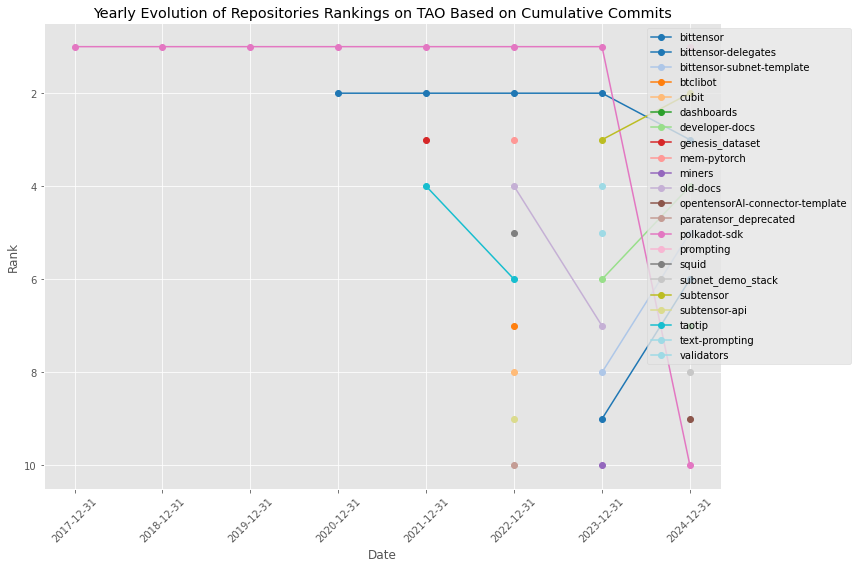

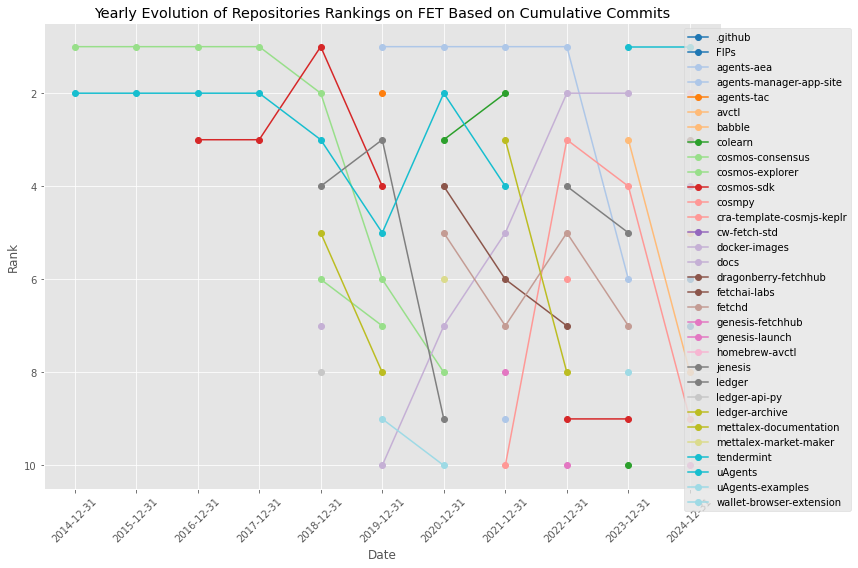

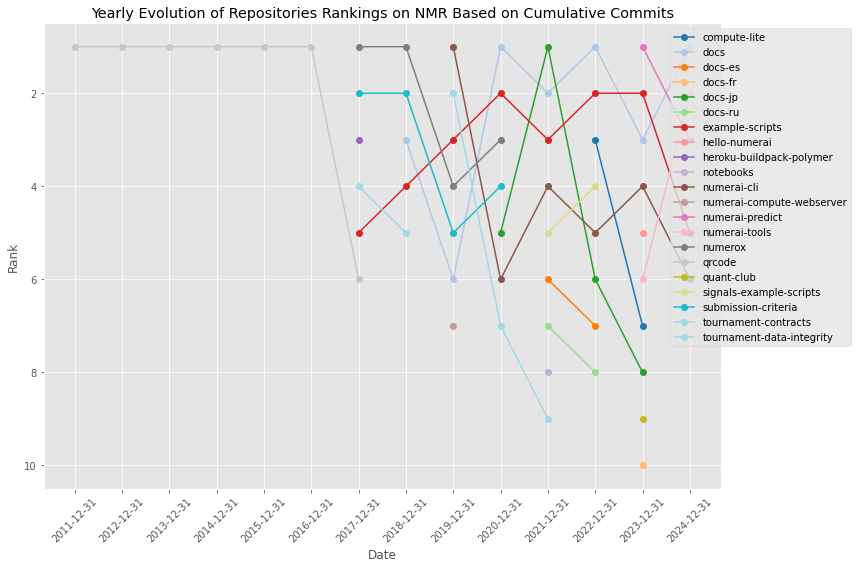

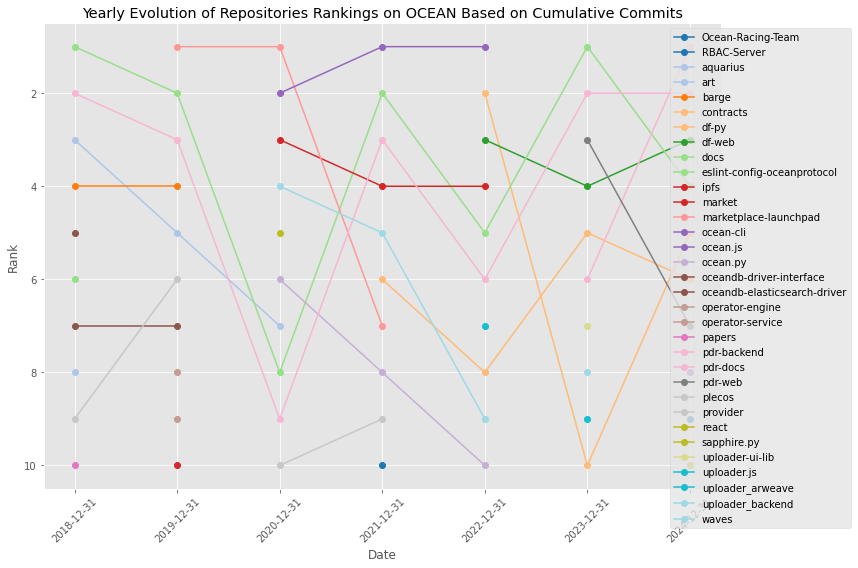

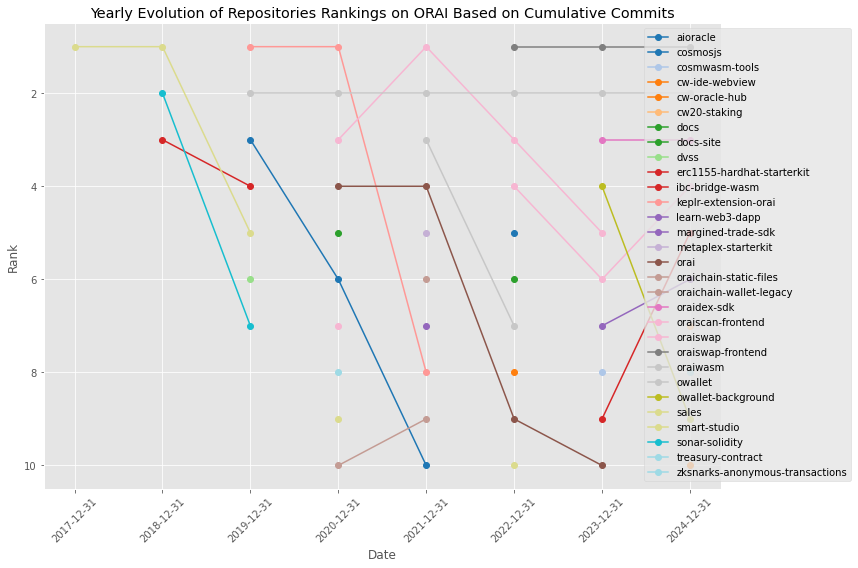

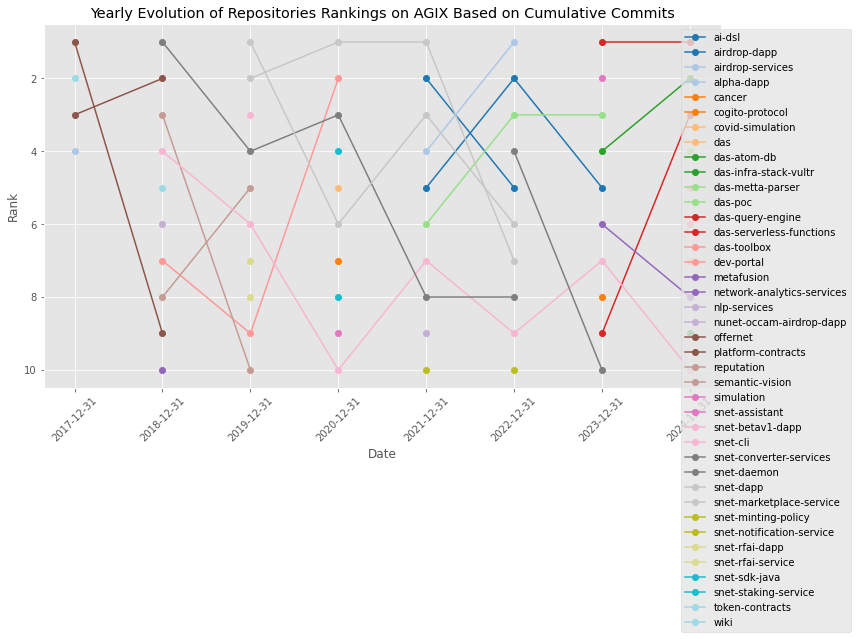

In [46]:
for i, token in enumerate(tokens):
    commits_data = get_commits(token, commits_mapping)
    year_commit_trend, _, _ = get_commit_trends(commits_data)
    year_commit_rank = preprocess_trends(year_commit_trend, token)

    
    plot_evolution_graph(year_commit_rank, 'Yearly', token)
    